## Visualize velocity fields for each glacier


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.features import rasterize
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error as MSE
import pwlf
import math
from scipy import stats
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import statsmodels.formula.api as smf
from hydroeval import *
def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    

In [121]:
gl = 2# number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet', 'Nordic','Zillmer']
glacier = ['kokanee', 'conrad', 'illecillewaet', 'nordic', 'zillmer']
path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'
fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'

In [106]:
VX = '/home/pelto/Desktop/velocity_mapping/zillmer/3m/zillmer_25m_vx_2018.tif'
VY = '/home/pelto/Desktop/velocity_mapping/zillmer/3m/zillmer_25m_vy_2018.tif'
VX = '/home/pelto/Desktop/velocity_mapping/zillmer/3m/zillmer_25m_vx_2016_blur1.tif'
VY = '/home/pelto/Desktop/velocity_mapping/zillmer/3m/zillmer_25m_vy_2016_blur1.tif'

VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20150419__img1_20160418_vmap_5m_51px_spm2/img1_20150419__img1_20160418_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20150419__img1_20160418_vmap_5m_51px_spm2/img1_20150419__img1_20160418_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20151003__img1_20160914_vmap_5m_51px_spm2/img1_20151003__img1_20160914_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20151003__img1_20160914_vmap_5m_51px_spm2/img1_20151003__img1_20160914_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20160418__img1_20170520_vmap_5m_51px_spm2/img1_20160418__img1_20170520_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20160418__img1_20170520_vmap_5m_51px_spm2/img1_20160418__img1_20170520_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20160914__img1_20171103_vmap_5m_51px_spm2/img1_20160914__img1_20171103_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20160914__img1_20171103_vmap_5m_51px_spm2/img1_20160914__img1_20171103_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20170520__img1_20180429_vmap_5m_51px_spm2/img1_20170520__img1_20180429_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20170520__img1_20180429_vmap_5m_51px_spm2/img1_20170520__img1_20180429_vmap_5m_51px_spm2-F_smooth_vy.tif'
VY='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20171103__img1_20180930_vmap_5m_51px_spm2/img1_20171103__img1_20180930_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX='/home/pelto/Desktop/velocity_mapping/zillmer/3m/img1_20171103__img1_20180930_vmap_5m_51px_spm2/img1_20171103__img1_20180930_vmap_5m_51px_spm2-F_smooth_vx.tif'

In [107]:
vy = salem.open_xr_dataset(VY);#vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
vy_reproj = vx.salem.transform(vy); vy = vy_reproj.to_array(name='vy')
msk = salem.open_xr_dataset(fl_path + 'zillmer_2015_extent_5m.tif')
msk_reproj = vx.salem.transform(msk); msk = msk_reproj.to_array(name='msk')


vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.1]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;

In [108]:
a=np.count_nonzero(~np.isnan(vz.data))
b=np.nansum(msk.data)
a/b

0.9975657589550216

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/datasets.py:173: RuntimeWarning: y0 out of bounds
  warnings.warn('y0 out of bounds', RuntimeWarning)


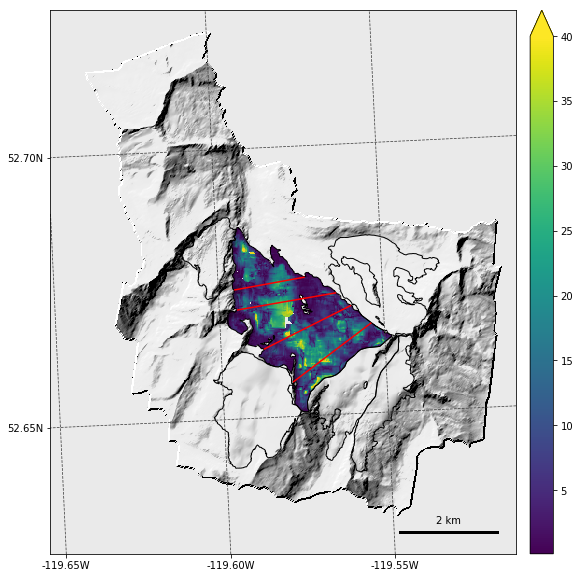

In [96]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(12,10)) #cm2inch(18, 8.25))
shpf = '/home/pelto/GIS/outlines/zillmer_divided_2015.shp'
gates = fl_path+'zillmer_flux_gates.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif'
dh_r = '/home/pelto/Desktop/lidar_cbt_analysis/zillmer/zillmer_2015_2016_dh_dt.tif'
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
gpr = salem.open_xr_dataset(fl_path + 'zillmer_gpr_50_100_5m_bilin.tif') 
gpr_reproj = vy.salem.transform(gpr);gpr = gpr_reproj.to_array(name='gpr')
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=40.);#sm.set_vmin(val=-10.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_topography(topo,  relief_factor=0.8)
sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/datasets.py:171: RuntimeWarning: x0 out of bounds
  warnings.warn('x0 out of bounds', RuntimeWarning)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/datasets.py:173: RuntimeWarning: y0 out of bounds
  warnings.warn('y0 out of bounds', RuntimeWarning)


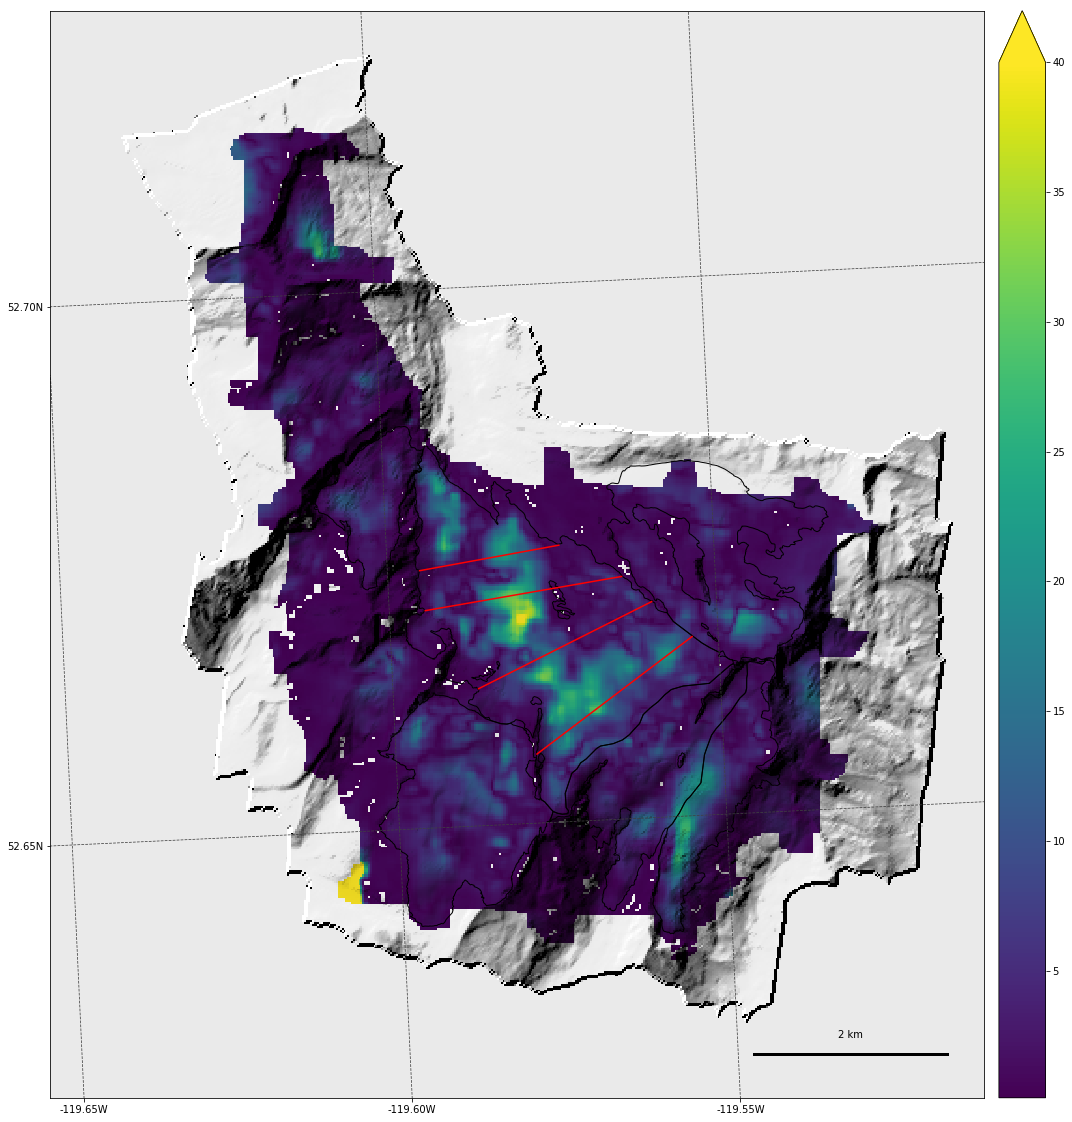

In [205]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = '/home/pelto/GIS/outlines/zillmer_divided_2015.shp'
gates = fl_path+'zillmer_flux_gates.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/zillmer/160914_zillmer_dem2.tif'
dh_r = '/home/pelto/Desktop/lidar_cbt_analysis/zillmer/zillmer_2015_2016_dh_dt.tif'
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
gpr = salem.open_xr_dataset(fl_path + 'zillmer_gpr_50_100_5m_bilin.tif') 
gpr_reproj = vy.salem.transform(gpr);gpr = gpr_reproj.to_array(name='gpr')
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=40.);#sm.set_vmin(val=-10.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_topography(topo,  relief_factor=0.8)
sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

In [83]:
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20160912__img1_20170927_vmap_5m_51px_spm2/img1_20160912__img1_20170927_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20160912__img1_20170927_vmap_5m_51px_spm2/img1_20160912__img1_20170927_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20170927__img1_20181014_vmap_5m_51px_spm2/img1_20170927__img1_20181014_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/img1_20170927__img1_20181014_vmap_5m_51px_spm2/img1_20170927__img1_20181014_vmap_5m_51px_spm2-F_smooth_vx.tif'

# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vx_25m_2016.tif'
# # VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vy_25m_2016.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vy_25m_2016b.tif'

# VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vx_25m_2018.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vx_25m_2018.tif'

# # VX = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vx_25m_alldem.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/nordic/3m/nordic_vy_25m_alldem.tif'


In [84]:
# ITS = '/home/pelto/Desktop/ice_flux/Nordic/ITS_LIVE/2018_nordic_ITS_LIVE_32611.tif'
# ITS = salem.open_xr_dataset(ITS);ITS = ITS.to_array(name='ITS')


vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
# vy_reproj = ITS.salem.transform(vy); vy = vy_reproj.to_array(name='vy')
# vx_reproj = ITS.salem.transform(vx); vx = vx_reproj.to_array(name='vx')
msk = salem.open_xr_dataset(fl_path + 'nordic_2015_extent_5m.tif')
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;#ITS.data[msk.data!=1.0] = np.nan

In [85]:
a=np.count_nonzero(~np.isnan(vz.data))
b=np.sum(msk.data)
a/b

0.9783010158431719

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/graphics.py:889: RuntimeWarning: invalid value encountered in less
  z[z < -999] = 0
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/graphics.py:852: RuntimeWarning: invalid value encountered in greater
  p = np.nonzero(slope > 0)


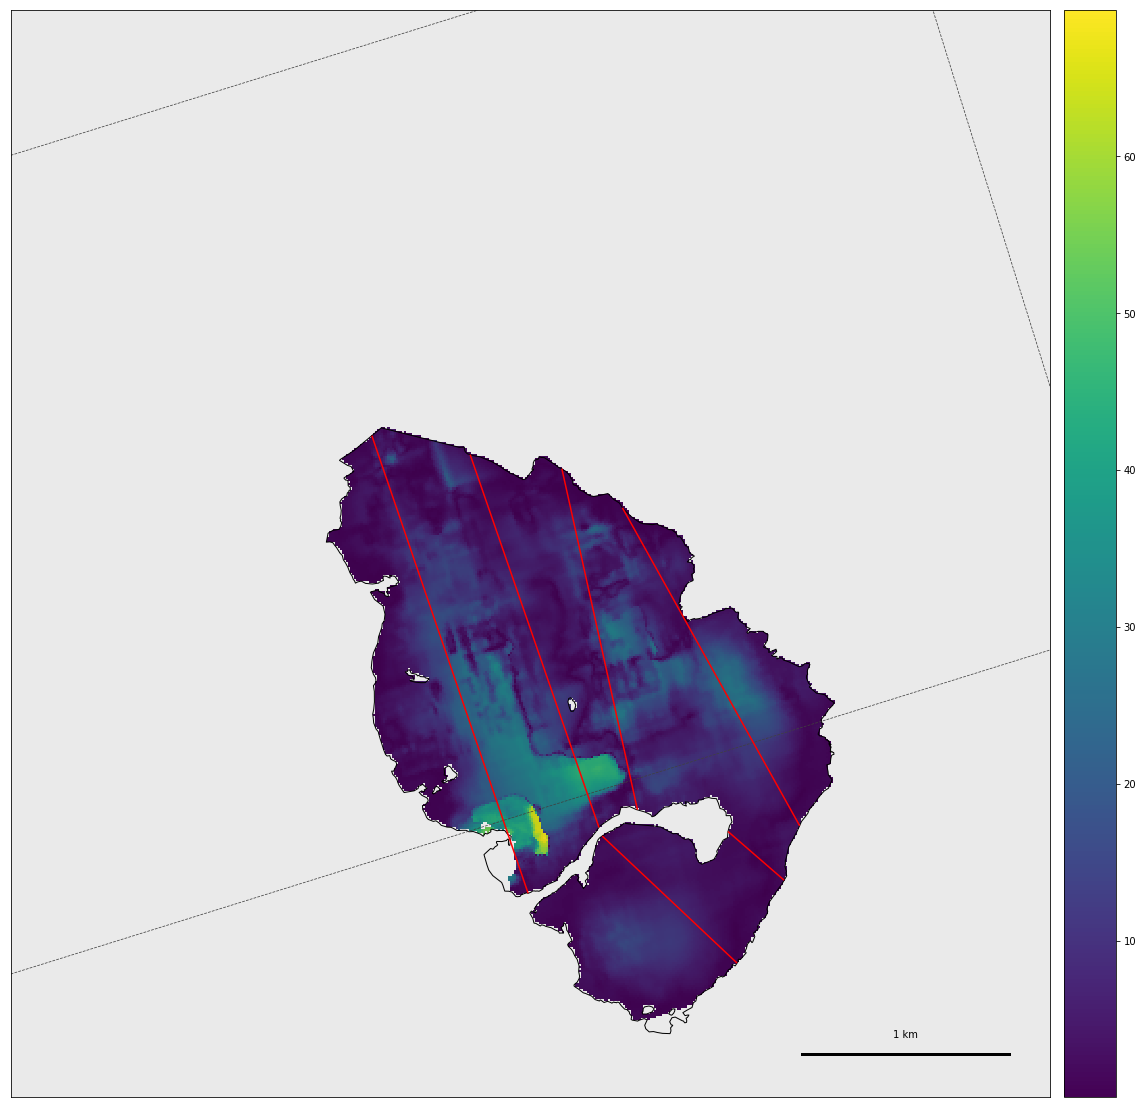

In [81]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = '/home/pelto/GIS/outlines/nordic_main__east_2014.shp'
gates = fl_path+'Nordic_flux_gates.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/nordic/20160912_nordic_dem1_clip_slave.tif'
dh_r = '/home/pelto/Desktop/lidar_cbt_analysis/nordic/nordic_2017clone_2016_dh_dt.tif'
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
grid = ITS.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
# sm.set_vmax(val=40.);#sm.set_vmin(val=-10.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_topography(topo,  relief_factor=0.8)
sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

In [82]:
# vy = salem.open_xr_dataset(VY);#vy = vy.to_array(name='vy')
# vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
# vy_reproj = vx.salem.transform(vy); vy = vy_reproj.to_array(name='vy')
# msk = salem.open_xr_dataset(fl_path + 'nordic_2015_extent_5m.tif')
# msk_reproj = vx.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

# vz = vy
# vz.data = np.sqrt(vx.data**2 + vz.data**2 )
# # vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
# # vz.data[msk.data!=1.0] = np.nan;

In [58]:
# print(np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk)))
# print(np.nanmean(vz[0].data))

In [59]:
diff= vz.data - ITS.data
np.nanmean(diff)

0.9365124

In [190]:
years = [2016, 2017, 2018]
for i in range(3):
       
    vf_list = ['nordic_vy_25m_2016.tif','nordic_vy_25m_2017.tif','nordic_vy_25m_2018.tif']
    vx_list = ['nordic_vx_25m_2016.tif','nordic_vx_25m_2017.tif','nordic_vx_25m_2018.tif']
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'
    ITS = fl_path + '/ITS_LIVE/'+str(year) + '_nordic_ITS_LIVE_32611.tif'
#     ITS = fl_path + '/ITS_LIVE/'+ 'nordic_ITS_LIVE_120m_composite.tif'
        
    VX = vdir+ vx_list[i];
    VY = vdir+ vf_list[i]
    ITS = salem.open_xr_dataset(ITS);ITS = ITS.to_array(name='ITS')
#     ITS_120 = salem.open_xr_dataset(ITS_120);ITS_120 = ITS_120.to_array(name='ITS')
    vy = salem.open_xr_dataset(VY);#vy = vy.to_array(name='vy')
    vx = salem.open_xr_dataset(VX);#vx = vx.to_array(name='vx')
    vy_reproj = ITS.salem.transform(vy); vy = vy_reproj.to_array(name='vy')
    vx_reproj = ITS.salem.transform(vx); vx = vx_reproj.to_array(name='vx')
    msk = salem.open_xr_dataset(fl_path + 'nordic_2015_extent_5m.tif')
    msk_reproj = ITS.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

    vz = vy
    vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    # vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
    vz.data[msk.data!=1.0] = np.nan;ITS.data[msk.data!=1.0] = np.nan
       
    year = years[i]
    d=ITS.data[~np.isnan(ITS.data)];d2=vz.data[~np.isnan(vz.data)];#d3=ITS_120.data[~np.isnan(ITS_120.data)];
    s = ['ITS'] * len(d);s2 = ['vz'] * len(d2);#s3 = ['ITS_120'] * len(d3)
    D=np.concatenate((d,d2),axis=0);S=np.concatenate((s,s2),axis=0)
    V = pd.DataFrame(pd.DataFrame(list(zip(D,S)),columns=['Vel','source']))
    #V['source'] = 'ITS'; V.source[V.index>len(d)]='vz'
    V['year'] = year
    if year == 2016:
        V1 = V.copy()
    if year == 2017:
        V2 = V.copy()
    if year == 2018:
        V3 = V.copy()
VA= pd.concat([V1, V2, V3], axis=0)

        

In [196]:
np.nanmean(V1.Vel[V.source=='ITS']),np.nanmean(V2.Vel[V.source=='ITS']),np.nanmean(V3.Vel[V.source=='ITS']),np.nanmean(VA.Vel[VA.source=='ITS'])

(3.4335404753685, 3.653918974539813, 3.203461239969029, 3.3560699176043274)

In [198]:
years = [2016, 2017, 2018]
for i in range(3):
       
    vf_list = ['nordic_vy_25m_2016.tif','nordic_vy_25m_2017.tif','nordic_vy_25m_2018.tif']
    vx_list = ['nordic_vx_25m_2016.tif','nordic_vx_25m_2017.tif','nordic_vx_25m_2018.tif']
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'
#     ITS = fl_path + '/ITS_LIVE/'+str(year) + '_nordic_ITS_LIVE_32611.tif'
    ITS = fl_path + '/ITS_LIVE/'+ 'nordic_ITS_LIVE_120m_composite.tif'
        
    VX = vdir+ vx_list[i];
    VY = vdir+ vf_list[i]
    ITS = salem.open_xr_dataset(ITS);ITS = ITS.to_array(name='ITS')
#     ITS_120 = salem.open_xr_dataset(ITS_120);ITS_120 = ITS_120.to_array(name='ITS')
    vy = salem.open_xr_dataset(VY);#vy = vy.to_array(name='vy')
    vx = salem.open_xr_dataset(VX);#vx = vx.to_array(name='vx')
    vy_reproj = ITS.salem.transform(vy); vy = vy_reproj.to_array(name='vy')
    vx_reproj = ITS.salem.transform(vx); vx = vx_reproj.to_array(name='vx')
    msk = salem.open_xr_dataset(fl_path + 'nordic_2015_extent_5m.tif')
    msk_reproj = ITS.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

    vz = vy
    vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    # vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
    vz.data[msk.data!=1.0] = np.nan;ITS.data[msk.data!=1.0] = np.nan
       
    year = years[i]
    d=ITS.data[~np.isnan(ITS.data)];d2=vz.data[~np.isnan(vz.data)];#d3=ITS_120.data[~np.isnan(ITS_120.data)];
    s = ['ITS'] * len(d);s2 = ['vz'] * len(d2);#s3 = ['ITS_120'] * len(d3)
    D=np.concatenate((d,d2),axis=0);S=np.concatenate((s,s2),axis=0)
    V = pd.DataFrame(pd.DataFrame(list(zip(D,S)),columns=['Vel','source']))
    #V['source'] = 'ITS'; V.source[V.index>len(d)]='vz'
    V['year'] = year
    if year == 2016:
        V1 = V.copy()
    if year == 2017:
        V2 = V.copy()
    if year == 2018:
        V3 = V.copy()
VB= pd.concat([V1, V2, V3], axis=0)

np.nanmean(V1.Vel[V.source=='ITS']),np.nanmean(V2.Vel[V.source=='ITS']),np.nanmean(V3.Vel[V.source=='ITS']),np.nanmean(VB.Vel[VB.source=='ITS'])        

(2.712819301510151, 2.712819301510151, 2.712819301510151, 2.712819301510151)

In [199]:
years = [2016, 2017, 2018]
for i in range(3):
       
    vf_list = ['nordic_vy_25m_2016.tif','nordic_vy_25m_2017.tif','nordic_vy_25m_2018.tif']
    vx_list = ['nordic_vx_25m_2016.tif','nordic_vx_25m_2017.tif','nordic_vx_25m_2018.tif']
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'
    ITS = fl_path + '/ITS_LIVE/'+str(year) + '_nordic_ITS_LIVE_32611.tif'
#     ITS = fl_path + '/ITS_LIVE/'+ 'nordic_ITS_LIVE_120m_composite.tif'
        
    VX = vdir+ vx_list[i];
    VY = vdir+ vf_list[i]
    ITS = salem.open_xr_dataset(ITS);#ITS = ITS.to_array(name='ITS')
#     ITS_120 = salem.open_xr_dataset(ITS_120);ITS_120 = ITS_120.to_array(name='ITS')
    vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
    vx = salem.open_xr_dataset(VX);#vx = vx.to_array(name='vx')
    ITS_reproj = vy.salem.transform(ITS); ITS = ITS_reproj.to_array(name='ITS')
    vx_reproj = vy.salem.transform(vx); vx = vx_reproj.to_array(name='vx')
    msk = salem.open_xr_dataset(fl_path + 'nordic_2015_extent_5m.tif')
    msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

    vz = vy
    vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    # vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
    vz.data[msk.data!=1.0] = np.nan;ITS.data[msk.data!=1.0] = np.nan
       
    year = years[i]
    d=ITS.data[~np.isnan(ITS.data)];d2=vz.data[~np.isnan(vz.data)];#d3=ITS_120.data[~np.isnan(ITS_120.data)];
    s = ['ITS'] * len(d);s2 = ['vz'] * len(d2);#s3 = ['ITS_120'] * len(d3)
    D=np.concatenate((d,d2),axis=0);S=np.concatenate((s,s2),axis=0)
    V = pd.DataFrame(pd.DataFrame(list(zip(D,S)),columns=['Vel','source']))
    #V['source'] = 'ITS'; V.source[V.index>len(d)]='vz'
    V['year'] = year
    if year == 2016:
        V1 = V.copy()
    if year == 2017:
        V2 = V.copy()
    if year == 2018:
        V3 = V.copy()
VC= pd.concat([V1, V2, V3], axis=0)

np.nanmean(V1.Vel[V.source=='ITS']),np.nanmean(V2.Vel[V.source=='ITS']),np.nanmean(V3.Vel[V.source=='ITS']),np.nanmean(VC.Vel[VC.source=='ITS'])  

(3.1680982440770564, 3.6462696623507407, 3.20807669535733, 3.340814867261709)

In [186]:
years

[2016, 2017, 2018]

In [200]:
vlist=[VC, VA, VB]
for n in range(3):
    
    v = vlist[n] 
    for i in range(3):
        year = years[i]
    #     print(np.nanmean(v.Vel[v.source=='ITS']))
        print(np.nanmean(v.Vel[(v.source=='ITS')&(v.year==year)]))

3.1680982440770564
3.6462696623507407
3.20807669535733
3.179706599882671
3.653918974539813
3.203461239969029
2.712819301510151
2.712819301510151
2.712819301510151


No handles with labels found to put in legend.
No handles with labels found to put in legend.


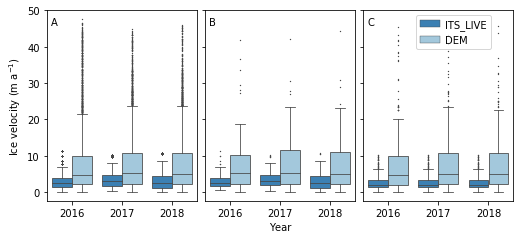

In [201]:
import seaborn as sns

fig, ax = plt.subplots(1,3, figsize=(cm2inch(18, 8)), sharey=True)
colors = ['#3182bd','#9ecae1','#deebf7']#['#003f5c','#bc5090','#ffa600']

vlist=[VC, VA, VB,];letter=['A','B','C']
for i in range(3):
    VA = vlist[i]
    Bob = sns.boxplot(x=VA.year, y=VA.Vel, hue=VA.source, palette=colors, saturation=0.85, 
                      linewidth=0.80, fliersize=0.5, ax=ax[i]) 
    
    leg = ax[2].legend(ncol = 1, bbox_to_anchor=[0.6,1.0],loc='upper center', handletextpad=0.5,columnspacing=0.95)
    new_labels = ['ITS_LIVE','DEM']
    for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
    ax[i].text(0.03, 0.92, letter[i], transform=ax[i].transAxes)
    ax[0].legend([],[], frameon=False);ax[1].legend([],[], frameon=False);
    ax[0].set(ylabel=('Ice velocity (m a$^{-1}$)'),xlabel=(''));ax[1].set(ylabel=(''),xlabel=('Year'));ax[2].set(ylabel=(''),xlabel=(''))
fig.subplots_adjust(bottom=0.13, top=0.97, hspace=0.05, left=0.075, right=0.99, wspace=0.05)
fig.savefig('/home/pelto/Desktop/ice_flux/figures/ITS_LIVE_nordic_comp.pdf', dpi=300) #ITS_LIVE_nordic_120m comp.pdf

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/graphics.py:889: RuntimeWarning: invalid value encountered in less
  z[z < -999] = 0
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/salem/graphics.py:852: RuntimeWarning: invalid value encountered in greater
  p = np.nonzero(slope > 0)


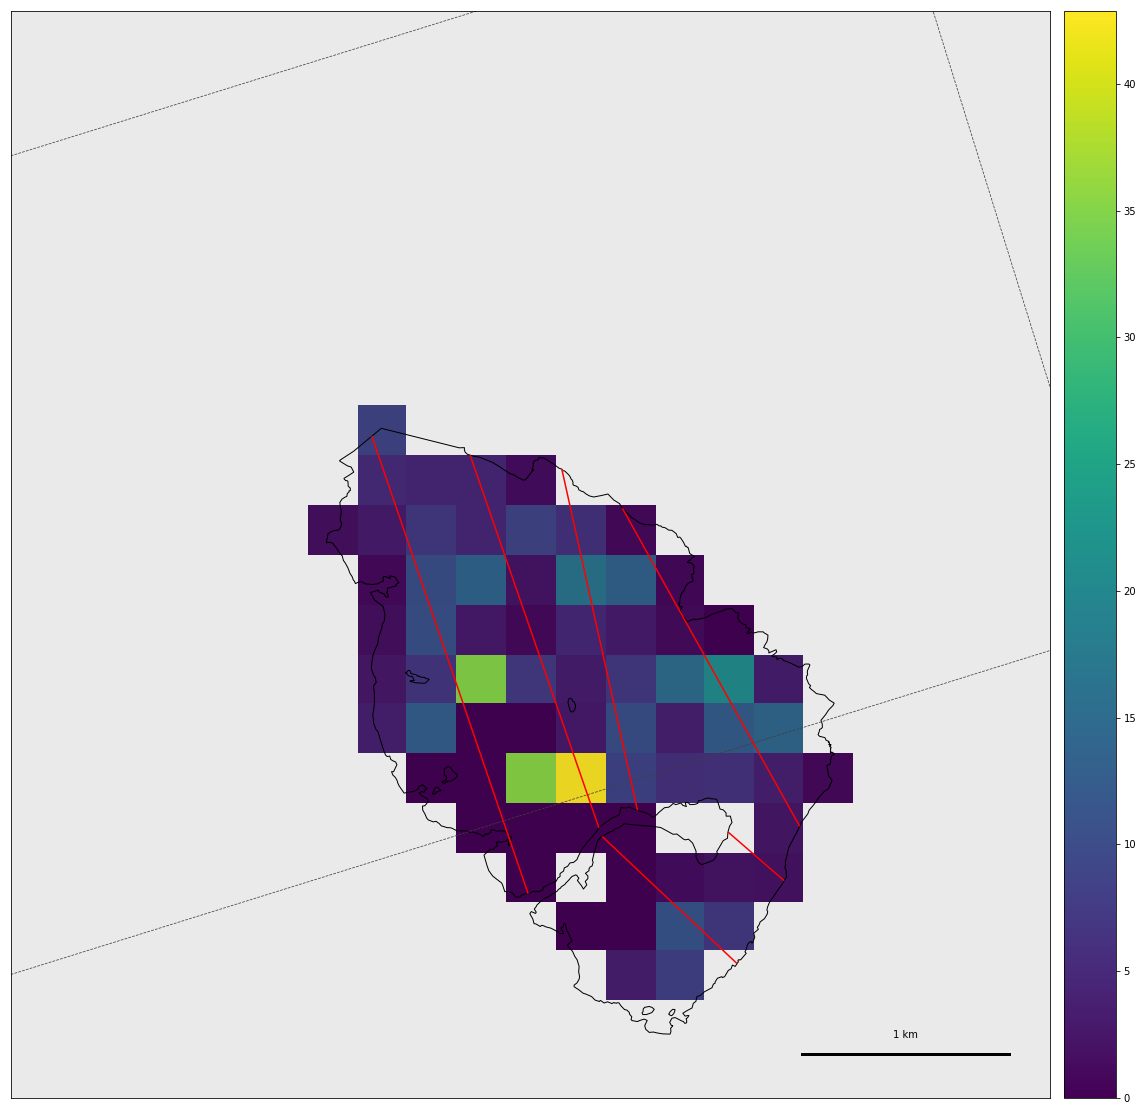

In [58]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = '/home/pelto/GIS/outlines/nordic_main__east_2014.shp'
gates = fl_path+'Nordic_flux_gates.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/nordic/20160912_nordic_dem1_clip_slave.tif'
dh_r = '/home/pelto/Desktop/lidar_cbt_analysis/nordic/nordic_2017clone_2016_dh_dt.tif'
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
grid = ITS.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
# sm.set_vmax(val=40.);#sm.set_vmin(val=-10.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_topography(topo,  relief_factor=0.8)
sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

In [62]:
#Kokanee

In [3]:
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vy.tif' 
# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'

VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vy_25m_2017.tif'
VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vx_25m_2017.tif'

# VY = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif'

#'/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/kokanee_vx_25m_2017.tif'

#YES# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vy.tif'
#YES# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES# /home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150912__img1_20160913_vmap_5m_51px_spm2/img1_20150912__img1_20160913_vmap_5m_51px_spm2-F_smooth_vy.tif
#YES#'/home/pelto/Desktop/velocity_mapping/kokanee/dem/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES#'/home/pelto/src/planet_tools/planet_tools/img1_20170929__img1_20180821_vmap_5m_51px_spm2/img1_20170929__img1_20180821_vmap_5m_51px_spm2-F_smooth_vy.tif'



#MAYBE# /home/pelto/src/planet_tools/planet_tools/img1_20170910__img1_20180821_vmap_5m_51px_spm2/img1_20170910__img1_20180821_vmap_5m_51px_spm2-F_smooth_vy.tif



In [29]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path + 'kokanee_2015_extent_5m.tif')
dh='/home/pelto/Desktop/lidar_cbt_analysis/kokanee/kokanee_2021_winter_dh.tif'
dh = salem.open_xr_dataset(dh);dh = dh.to_array(name='dh')
msk_reproj = dh.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

# msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')

# vx = salem.open_xr_dataset(VX);;vm = salem.open_xr_dataset(VM)
# vm = vm.to_array(name='vm');#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
# vx_reproj = vm.salem.transform(vx);vy_reproj = vm.salem.transform(vy)
# vx = vx_reproj.to_array(name='vx');vy = vy_reproj.to_array(name='vy')

In [11]:
# vy.data[vy.data<0.01]=np.nan
vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;


IndexError: boolean index did not match indexed array along dimension 1; dimension is 321 but corresponding boolean dimension is 15960

In [ ]:
print(np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk)))
print(np.nanmean(vz[0].data))

In [33]:
dh.data[dh.data<-6.0] = np.nan;
# dh.data[msk.data!=1.0] = np.nan;

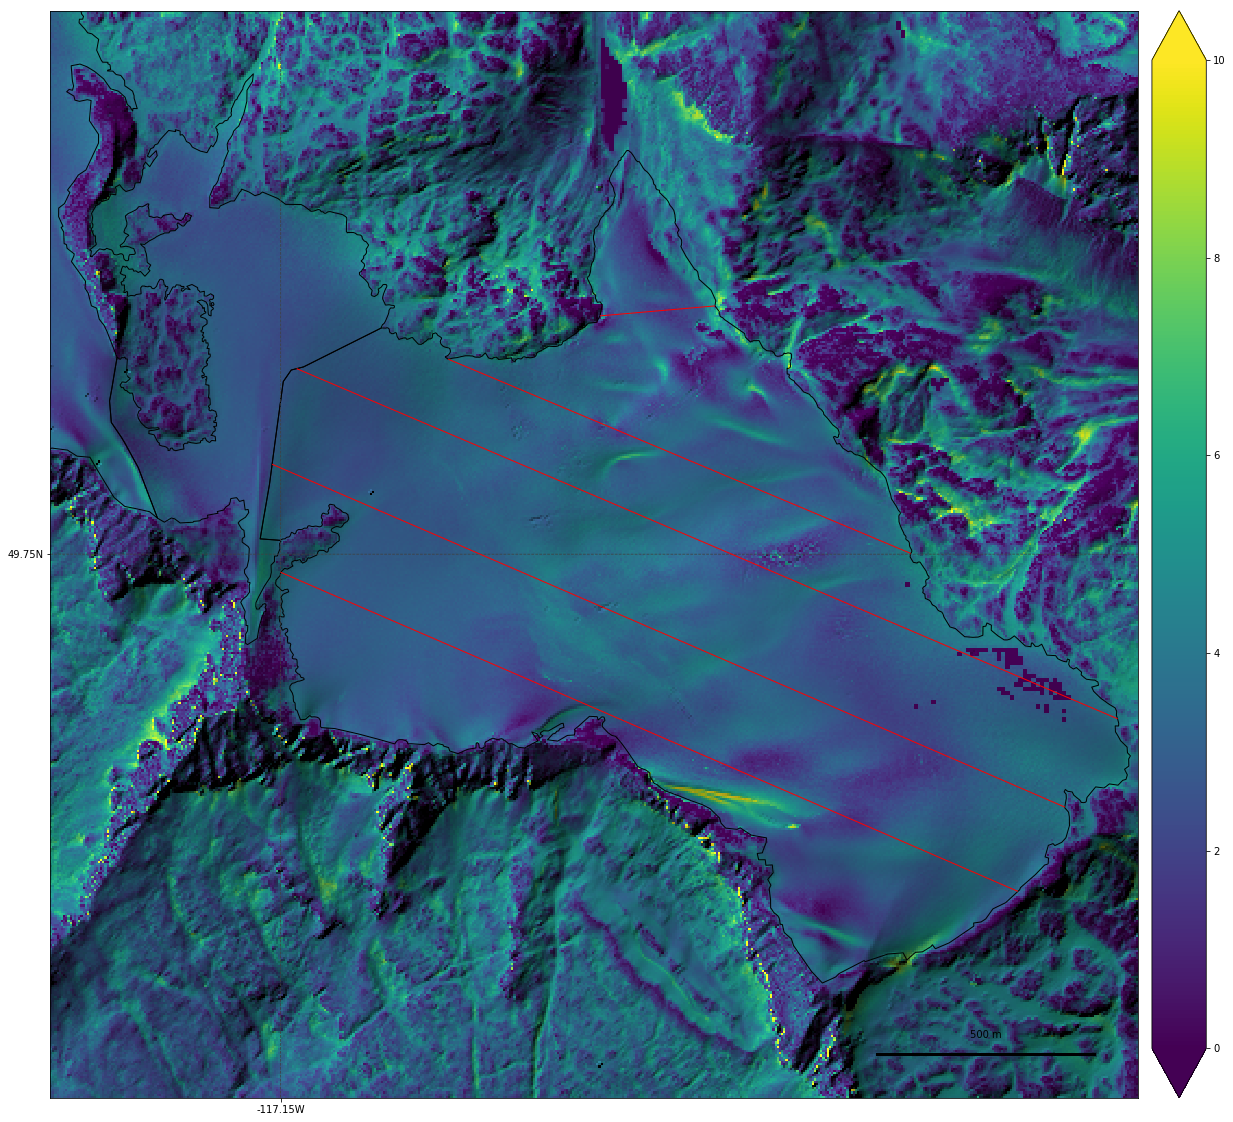

In [30]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = path + Glacier[gl] + '/kok_all_glaciers_2015_dem.shp' #'/conrad_all_glaciers_2014.shp'
gates = fl_path+'Kok_flux_gates_6.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif'
grid = vy.salem.grid  ##full view
grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(dh) #, label='m')
sm.set_vmax(val=10.);sm.set_vmin(val=0.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

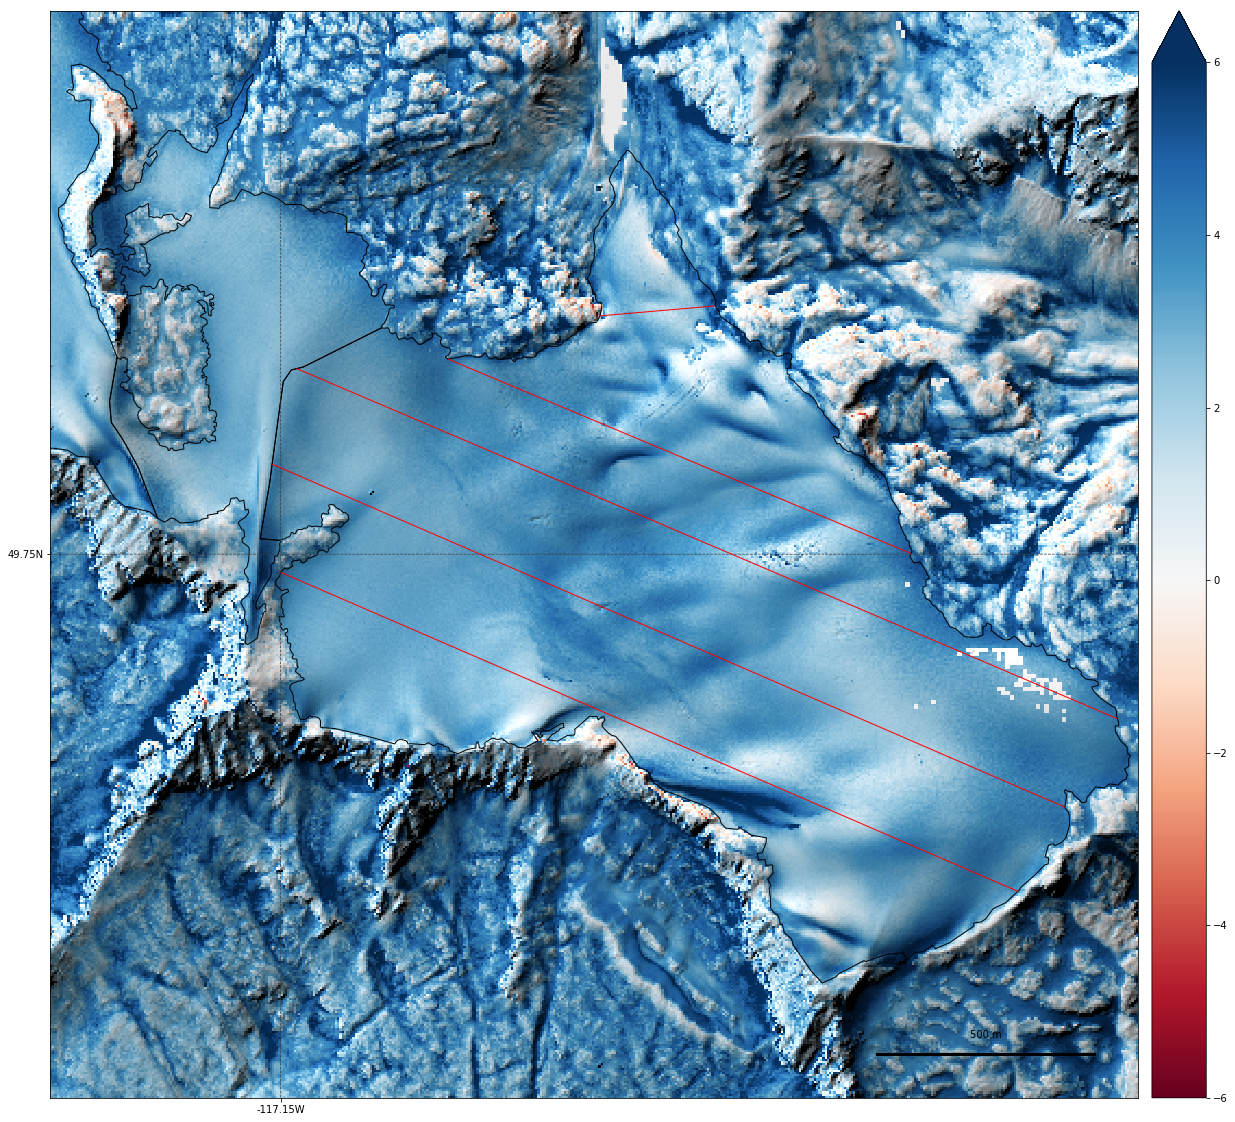

In [34]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(24,20)) #cm2inch(18, 8.25))
shpf = path + Glacier[gl] + '/kok_all_glaciers_2015_dem.shp' #'/conrad_all_glaciers_2014.shp'
gates = fl_path+'Kok_flux_gates_6.shp'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20181014_Kokanee_dem1_clip_slave.tif'
grid = vy.salem.grid  ##full view
grid = mercator_grid(center_ll=(-117.14, 49.75), extent=(2500, 2500))
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_cmap("RdBu")#"Blues")
sm.set_scale_bar()
sm.set_data(dh) #, label='m')
sm.set_vmax(val=6.);sm.set_vmin(val=-6.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

In [35]:
print(np.nanmean(dh))
print(np.nanmean(dh)*0.431)
print(np.nanmean(dh)*0.470)
# dh.data[dh.data<0.0] = np.nan;

2.8051953
1.2090391879081726
1.3184418058395384


In [36]:
dh.data[dh.data<-6.0] = np.nan;
dh.data[dh.data>0.0] = np.nan;
dh.data[msk.data==1.0] = np.nan;
np.nanmean(dh)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


-0.97577643

# Conrad

In [111]:
year=2018
vf_list = ['conrad_2016_vy_25m_pos.tif','conrad_2017_vy_25m_pos.tif','conrad_2018_vy_25m_pos_17mos.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/' +Glacier[gl] + '_DEMs/spm2/3m/'
ITS = fl_path + 'ITS_Live/' + str(year) + '_conrad_ITS_LIVE.tif'
I = np.abs(year - 2016) 
### for 2016/7
# VX = vdir+ vf_list[I][:-14] + 'vx_25m.tif' 
# VY = vdir+ vf_list[I]
# VM = vdir+ vf_list[I][:-14] + 'vm_25m.tif'

In [118]:
VY = '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_51px_spm2/img1_20170904__img2_20180822_vmap_5m_51px_spm2-F_smooth_vy.tif'
VX = '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_51px_spm2/img1_20170904__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif'
VY = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/conrad_2016_vy_25m_pos_blur1.tif'
VX = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/conrad_2016_vx_25m_blur1.tif'  
VX = vdir+ 'conrad_all_3mdems+planet_25m_vx.tif' #'conrad_fast_vy.tif'
VY = vdir+ 'conrad_all_3mdems+planet_25m_vy.tif' 
ITS = fl_path +  'mosaic_conrad_ITS_LIVE.tif'

#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20170521__img2_20180426_vmap_5m_51px_spm2/img1_20170521__img2_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160912__img2_20170917_vmap_5m_51px_spm2/img1_20160912__img2_20170917_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150912__img1_20160912_vmap_5m_51px_spm2/img1_20150912__img1_20160912_vmap_5m_51px_spm2-F_smooth_vx.tif'
#YES /home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150420__img1_20160417_vmap_5m_51px_spm2/img1_20150420__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy.tif

In [119]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif') 
dhA_list = ['conrad_2015_2016_dh_dt_filled_1416+50cm.tif', 'conrad_2017_2016_dh_dt_17s14m.tif','conrad_2018_2017_dh_dt.tif']
#'conrad_2016_2017_dh_dt+50cm.tif'

dh_r = path+  dhA_list[I]
dh = salem.open_xr_dataset(dh_r); dh_reproj = vy.salem.transform(dh); dh = dh_reproj.to_array(name='dh')#dh.data[dh.data<1] = np.nan
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
ITS = salem.open_xr_dataset(ITS); ITS_reproj = vy.salem.transform(ITS);ITS = ITS_reproj.to_array(name='ITS')

vz = vy; vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vz.data[vz.data>30.0]=vz.data[vz.data>30.0]*0.5 ##remove high erroneous values
vz.data[msk.data!=1.0] = np.nan;
dh.data[msk.data!=1.0] = np.nan;
np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(msk)

RasterioIOError: /home/pelto/Desktop/ice_flux/Conrad/mosaic_conrad_ITS_LIVE.tif: No such file or directory

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

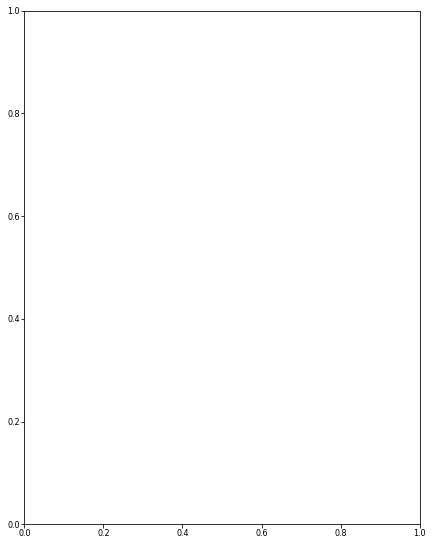

In [120]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1'
pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(18,24))
topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/dem_mosaic_conrad.tif'
grid = mercator_grid(center_ll=(-116.92, 50.802), extent=(5500, 7500)) ##zoomed out view
# grid = mercator_grid(center_ll=(-116.92, 50.81), extent=(7500, 7500))
sm1 = Map(grid, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.12, 0.05),add_bbox=True,bbox_dy=1.4,linewidth=1.0)
import xarray as xr
VZA=xr.DataArray(data=vz, coords=vz.coords, dims=vz.dims, name='VZA', attrs=vz.attrs) #,indexes=vx.indexes fastpath=False)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(ITS) 

sm1.set_cmap("Spectral_r")
# sm1.set_cmap("RdBu")
# sm1.set_vmin(val=-6.);sm1.set_vmax(val=6.)
sm1.set_vmax(val=60)
shape = salem.read_shapefile('/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_16_extent.shp')
gates = salem.read_shapefile('/home/pelto/Desktop/ice_flux/Conrad/conrad_flux_gates_new11.shp')
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo,  relief_factor=0.8)
sm1.set_shapefile(shape, lw=1.5, color='w')
sm1.set_shapefile(gates, color='w', lw=1.1)
sm1.append_colorbar(ax=ax, pad=0.1, label='Ice Velocity (m yr$^{-1}$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm1.plot(ax=ax)

# u = df_agg.vx.values
# v = df_agg.vy.values

# X, Y = np.meshgrid(df_agg.lon,df_agg.lat)

# # transform their coordinates to the map reference system and plot the arrows
# xx, yy = sm1.grid.transform(df_agg.lon, df_agg.lat, crs=salem.wgs84)#sm1.grid.proj

# # xx, yy = np.meshgrid(xx,yy)

# # qu = ax.quiver(xx, yy, u, v)

# ###### start:stop:step
# Q = ax.quiver(xx[::2], yy[::2], u[::2], v[::2])  #, pivot='mid')
# qk = ax.quiverkey(Q, 0.07, 0.10, 40, r'$40 \frac{m}{a}$', labelpos='N', coordinates='figure', labelsep=0.025)

fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
# plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_' +str(year) +'_vel_gates_quiver_2016.pdf', dpi=300)
print(str(year))

# Illecillewaet

In [125]:
# VY = '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vy.tif'
# VX = '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif'

# VX= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY ='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160912_vmap_5m_51px_spm2/img1_20150911__img1_20160912_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150419__img1_20160417_vmap_5m_51px_spm2/img1_20150419__img1_20160417_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# # VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vx_clean2.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160417__img1_20170521_vmap_5m_51px_spm2/img1_20160417__img1_20170521_vmap_5m_51px_spm2-F_smooth_vy_clean.tif'
# VX='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif'
# VY='/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vy.tif'

VX= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/illecillewaet_2016_all25m_vx.tif'
VY= '/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/illecillewaet_2016_all25m_vy.tif'

vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/';vf = 'illecillewaet_all_dem3m_'
VX = vdir + vf + 'blur1_25m_vx_neg.tif' #'vx_best_neg_5m.tif'
VY = vdir + vf + 'blur1_25m_vy.tif'


# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img1_20160830__img2_20170822_vmap_5m_51px_spm2/img1_20160830__img2_20170822_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img1_20160830__img2_20170911_vmap_5m_51px_spm2/img1_20160830__img2_20170911_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160912__img1_20170917_vmap_5m_51px_spm2/img1_20160912__img1_20170917_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170521__img1_20180426_vmap_5m_51px_spm2/img1_20170521__img1_20180426_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_51px_spm2/img1_20170917__img2_20181016_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img2_20170822__img2_20180822_vmap_5m_51px_spm2/img2_20170822__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif
# /home/pelto/Desktop/velocity_mapping/illecillewaet/illec_planet/img2_20170911__img2_20180822_vmap_5m_51px_spm2/img2_20170911__img2_20180822_vmap_5m_51px_spm2-F_smooth_vx.tif

In [126]:
# year =2017
# I = np.abs(year - 2016) 
# vf_list = ['illecillewaet_2016_all25m_vx.tif','illecillewaet_2017_all25m_vx.tif','illecillewaet_2018_all25m_vx.tif']
# vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' 
# VX = vdir+ vf_list[I]
# VY = vdir+ vf_list[I][:-7] + '_vy.tif' 

In [127]:
vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path+'illecillewaet_2014_extent_5m.tif') 
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
msk.data[msk.data<0.0]=np.nan


vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan;# vy.data[vy.data>50.0]=np.nan
vz.data[msk.data!=1.0] = np.nan;
np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk))

0.9883249554078158

In [128]:
np.nanmean(vz)

14.808546

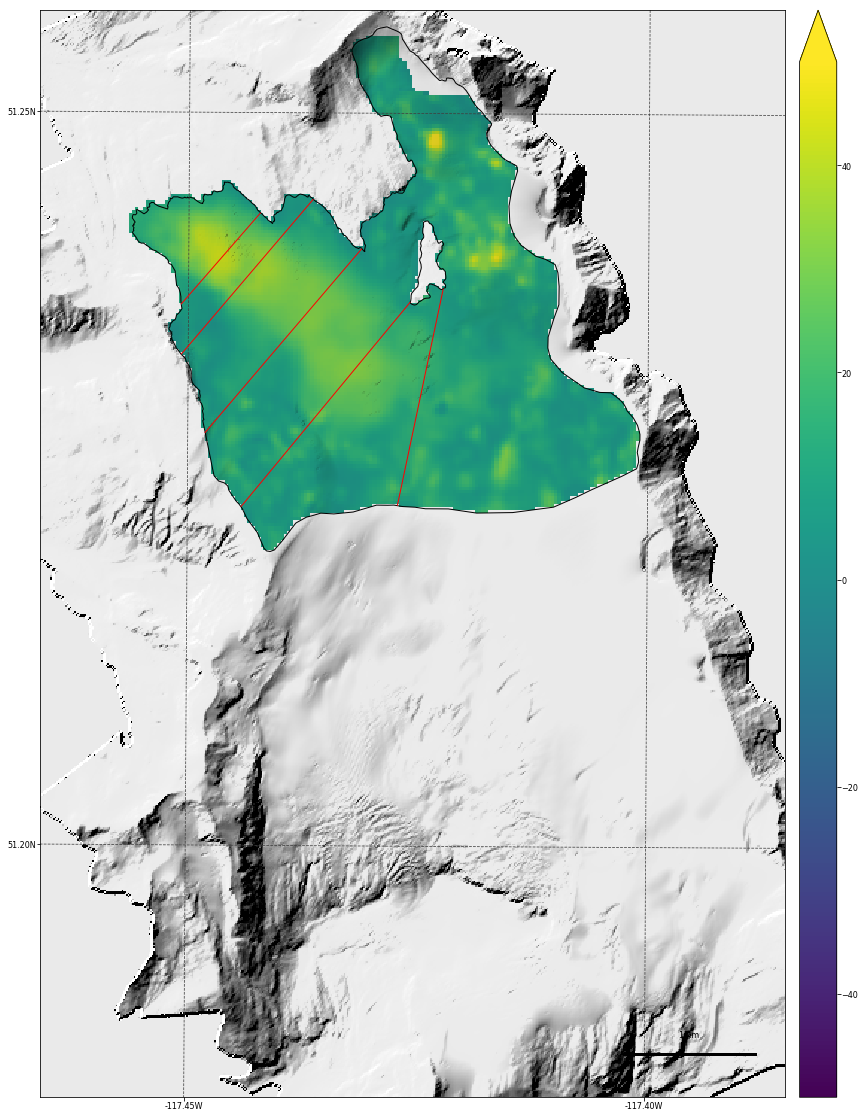

In [129]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,20)) #cm2inch(18, 8.25))
pts_file = fl_path + 'Illec_flux_gates_5_pts_20m.shp'  ##must be WGS84 currently
gates = fl_path+'Illec_flux_gates_5.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   
topo = path + '160912_illecillewaet_dem1_clip_master.tif'
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
# sm.set_cmap("RdBu")
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=50.);sm.set_vmin(val=-50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,20)) #cm2inch(18, 8.25))
pts_file = fl_path + 'Illec_flux_gates_16_pts_20m_new.shp'  ##must be WGS84 currently
gates = fl_path+'Illec_flux_gates_new.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   
topo = path + '160912_illecillewaet_dem1_clip_master.tif'
grid = vy.salem.grid  ##full view
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vz) #, label='m')
sm.set_vmax(val=60.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
# print(np.nanmean(VZ))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1, color='r')
sm.set_topography(topo,  relief_factor=0.8)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.plot(ax=ax)
sm.visualize(ax=ax)
plt.show()